In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

#%aimport deepsvr

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import tensorflow

c:\users\minie\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\minie\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\minie\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\minie\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dty

In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

Using TensorFlow backend.


In [5]:
#import sys
#sys.path.insert(0, r'/DeepSVR/analysis_utils/')

from DeepSVR.analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
from DeepSVR.analysis_utils.Analysis import print_accuracy_and_classification_report, predict_classes, get_somatic_error_type

sns.set_style("white")
sns.set_context('poster')

In [21]:
data = pd.read_csv('GSE68086_TEP_data_matrix.txt', header=0, sep='\t')

In [9]:
!pip install xlrd

In [28]:
features = pd.read_excel('features_rank.xlsx', header=3)
features = features[:2047]

In [30]:
top = features['Feature name'].tolist()
len(top)

2047

In [22]:
data.loc[:,'SUM'] = (data == 0).astype(int).sum(axis=1)
data.head()

,Unnamed: 0,3-Breast-Her2-ampl,8-Breast-WT,10-Breast-Her2-ampl,Breast-100,15-Breast-Her2-ampl,16-Breast-WT,21-Breast-WT,33-Breast-Her2-ampl,42-Breast-Her2-ampl,...,MGH-NSCLC-L22-TR462,MGH-NSCLC-L23-TR524,MGH-NSCLC-L25-TR480,MGH-NSCLC-L39-TR519,MGH-NSCLC-L40-TR520,MGH-NSCLC-L51-TR521,MGH-NSCLC-L58-TR525,MGH-NSCLC-L59-TR522,MGH-NSCLC-L65-TR523,SUM
0,ENSG00000000003,0,0,0,0,17,0,0,0,0,...,5,10,9,0,0,0,0,0,0,211
1,ENSG00000000005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,284
2,ENSG00000000419,44,14,16,8,9,0,139,108,55,...,41,40,15,1,0,13,0,0,10,52
3,ENSG00000000457,26,1,14,0,4,20,1,26,24,...,0,0,0,0,0,0,0,0,0,138
4,ENSG00000000460,81,98,18,17,0,20,144,26,97,...,1,6,22,30,0,1,50,6,2,23


In [23]:
data = data[data.SUM < 257]
len(data)

13445

In [25]:
data['Unnamed: 0']

0        ENSG00000000003
2        ENSG00000000419
3        ENSG00000000457
4        ENSG00000000460
5        ENSG00000000938
              ...       
57637    ENSG00000273329
57645    ENSG00000273341
57648    ENSG00000273344
57655    ENSG00000273356
57730    ENSG00000273486
Name: Unnamed: 0, Length: 13445, dtype: object

In [35]:
top_features = data[data['Unnamed: 0'].isin(top)]
top_features = top_features.set_index('Unnamed: 0')
top_features

,3-Breast-Her2-ampl,8-Breast-WT,10-Breast-Her2-ampl,Breast-100,15-Breast-Her2-ampl,16-Breast-WT,21-Breast-WT,33-Breast-Her2-ampl,42-Breast-Her2-ampl,Breast-454,...,MGH-NSCLC-L22-TR462,MGH-NSCLC-L23-TR524,MGH-NSCLC-L25-TR480,MGH-NSCLC-L39-TR519,MGH-NSCLC-L40-TR520,MGH-NSCLC-L51-TR521,MGH-NSCLC-L58-TR525,MGH-NSCLC-L59-TR522,MGH-NSCLC-L65-TR523,SUM
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ENSG00000002016,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,233
ENSG00000002330,13,16,10,1,8,5,21,13,11,6,...,27,59,60,76,13,47,57,37,49,5
ENSG00000003402,251,332,281,80,97,168,584,174,219,106,...,94,120,93,93,73,82,311,53,74,0
ENSG00000003756,63,17,32,26,121,44,39,47,73,7,...,70,34,0,0,0,0,0,85,4,45
ENSG00000004059,454,355,319,62,330,98,247,271,163,62,...,273,655,500,743,380,558,621,261,582,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000272468,3,1,5,1,2,3,0,0,4,5,...,5,5,5,11,1,8,9,0,0,51
ENSG00000272562,1,3,1,1,0,0,2,0,0,5,...,4,3,1,2,0,1,1,0,0,136
ENSG00000272622,7,0,0,0,4,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,255


In [36]:
dataset = top_features.drop(['SUM'], axis=1)
dataset_transposed = dataset.T
dataset_transposed['class'] = dataset_transposed.index
dataset_transposed.reset_index(drop=True, inplace=True)

dataset_transposed['class'] = dataset_transposed['class'].apply(lambda x: "B" if  "Breast" in x else x)
dataset_transposed['class'] = dataset_transposed['class'].apply(lambda x: "B" if  "BrCa" in x else x)
dataset_transposed['class'] = dataset_transposed['class'].apply(lambda x: "N" if  "NSCLC" in x else x)
dataset_transposed['class'] = dataset_transposed['class'].apply(lambda x: "N" if  "Lung" in x else x)
dataset_transposed['class'] = dataset_transposed['class'].apply(lambda x: "D" if  "HD" in x else x)
dataset_transposed['class'] = dataset_transposed['class'].apply(lambda x: "D" if  "Control" in x else x)
dataset_transposed['class'] = dataset_transposed['class'].apply(lambda x: "P" if  "Panc" in x else x)
dataset_transposed['class'] = dataset_transposed['class'].apply(lambda x: "G" if  "GBM" in x else x)
dataset_transposed['class'] = dataset_transposed['class'].apply(lambda x: "H" if  "Chol" in x else x)
dataset_transposed['class'] = dataset_transposed['class'].apply(lambda x: "H" if  "Liver" in x else x)
dataset_transposed['class'] = dataset_transposed['class'].apply(lambda x: "C" if  "CRC" in x else x)

dataset_transposed = dataset_transposed[~dataset_transposed['class'].str.contains("Type-Unknown")]
dataset_transposed = dataset_transposed[~dataset_transposed['class'].str.contains("Platelet-hiseq")]

dataset_transposed['class'].value_counts()

N    59
D    54
C    44
B    38
G    38
P    33
H    12
Name: class, dtype: int64

In [37]:
len(dataset_transposed)

278

In [38]:
columns = dataset_transposed.columns
column_name =  columns[:-1]

# 6 types of cancer classifier

In [39]:
# Get labels for training data
Y = dataset_transposed['class'].values
X = dataset_transposed.drop(['class'], axis=1).values

# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [40]:
# Determine shape of training data features for cross-validation
X_train.shape

(222, 2047)

In [41]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(222,)

In [42]:
# Set parameters for the Random Forest Model
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
label_encoder = preprocessing.MultiLabelBinarizer()
label_encoder.fit(Y)

MultiLabelBinarizer()

In [43]:
Y_one_hot = label_encoder.fit_transform(Y_train)
print(list(label_encoder.classes_))

['B', 'C', 'D', 'G', 'H', 'N', 'P']


Select Parameters

In [44]:
from sklearn.model_selection import GridSearchCV

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [45]:
param_rf = { 
    'n_estimators': [10, 100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_rf, 
                          cv = kfold, verbose = 3 , refit = True)
grid_search_rf.fit(X_train, Y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.348, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.435, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.455, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.318, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.318, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.500, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.500, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.545, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.500, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.545, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=100 .............
[CV]  criterion=gini, max_features=auto, n_estimators=100, score

[CV]  criterion=gini, max_features=sqrt, n_estimators=10, score=0.591, total=   0.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=100 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=100, score=0.435, total=   0.4s
[CV] criterion=gini, max_features=sqrt, n_estimators=100 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=100, score=0.348, total=   0.3s
[CV] criterion=gini, max_features=sqrt, n_estimators=100 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=100, score=0.455, total=   0.4s
[CV] criterion=gini, max_features=sqrt, n_estimators=100 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=100, score=0.273, total=   0.4s
[CV] criterion=gini, max_features=sqrt, n_estimators=100 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=100, score=0.364, total=   0.4s
[CV] criterion=gini, max_features=sqrt, n_estimators=100 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=100, 

[CV]  criterion=gini, max_features=log2, n_estimators=100, score=0.409, total=   0.2s
[CV] criterion=gini, max_features=log2, n_estimators=100 .............
[CV]  criterion=gini, max_features=log2, n_estimators=100, score=0.227, total=   0.2s
[CV] criterion=gini, max_features=log2, n_estimators=100 .............
[CV]  criterion=gini, max_features=log2, n_estimators=100, score=0.409, total=   0.2s
[CV] criterion=gini, max_features=log2, n_estimators=100 .............
[CV]  criterion=gini, max_features=log2, n_estimators=100, score=0.318, total=   0.2s
[CV] criterion=gini, max_features=log2, n_estimators=100 .............
[CV]  criterion=gini, max_features=log2, n_estimators=100, score=0.591, total=   0.2s
[CV] criterion=gini, max_features=log2, n_estimators=100 .............
[CV]  criterion=gini, max_features=log2, n_estimators=100, score=0.727, total=   0.2s
[CV] criterion=gini, max_features=log2, n_estimators=100 .............
[CV]  criterion=gini, max_features=log2, n_estimators=100,

[CV]  criterion=entropy, max_features=auto, n_estimators=100, score=0.364, total=   0.6s
[CV] criterion=entropy, max_features=auto, n_estimators=100 ..........
[CV]  criterion=entropy, max_features=auto, n_estimators=100, score=0.318, total=   0.6s
[CV] criterion=entropy, max_features=auto, n_estimators=100 ..........
[CV]  criterion=entropy, max_features=auto, n_estimators=100, score=0.591, total=   0.7s
[CV] criterion=entropy, max_features=auto, n_estimators=100 ..........
[CV]  criterion=entropy, max_features=auto, n_estimators=100, score=0.682, total=   0.6s
[CV] criterion=entropy, max_features=auto, n_estimators=100 ..........
[CV]  criterion=entropy, max_features=auto, n_estimators=100, score=0.727, total=   0.6s
[CV] criterion=entropy, max_features=auto, n_estimators=100 ..........
[CV]  criterion=entropy, max_features=auto, n_estimators=100, score=0.636, total=   0.6s
[CV] criterion=entropy, max_features=auto, n_estimators=200 ..........
[CV]  criterion=entropy, max_features=au

[CV]  criterion=entropy, max_features=sqrt, n_estimators=100, score=0.682, total=   0.6s
[CV] criterion=entropy, max_features=sqrt, n_estimators=100 ..........
[CV]  criterion=entropy, max_features=sqrt, n_estimators=100, score=0.636, total=   0.6s
[CV] criterion=entropy, max_features=sqrt, n_estimators=100 ..........
[CV]  criterion=entropy, max_features=sqrt, n_estimators=100, score=0.545, total=   0.6s
[CV] criterion=entropy, max_features=sqrt, n_estimators=100 ..........
[CV]  criterion=entropy, max_features=sqrt, n_estimators=100, score=0.818, total=   0.7s
[CV] criterion=entropy, max_features=sqrt, n_estimators=200 ..........
[CV]  criterion=entropy, max_features=sqrt, n_estimators=200, score=0.391, total=   1.2s
[CV] criterion=entropy, max_features=sqrt, n_estimators=200 ..........
[CV]  criterion=entropy, max_features=sqrt, n_estimators=200, score=0.435, total=   1.2s
[CV] criterion=entropy, max_features=sqrt, n_estimators=200 ..........
[CV]  criterion=entropy, max_features=sq

[CV]  criterion=entropy, max_features=log2, n_estimators=100, score=0.591, total=   0.3s
[CV] criterion=entropy, max_features=log2, n_estimators=100 ..........
[CV]  criterion=entropy, max_features=log2, n_estimators=100, score=0.545, total=   0.3s
[CV] criterion=entropy, max_features=log2, n_estimators=200 ..........
[CV]  criterion=entropy, max_features=log2, n_estimators=200, score=0.435, total=   0.6s
[CV] criterion=entropy, max_features=log2, n_estimators=200 ..........
[CV]  criterion=entropy, max_features=log2, n_estimators=200, score=0.435, total=   0.5s
[CV] criterion=entropy, max_features=log2, n_estimators=200 ..........
[CV]  criterion=entropy, max_features=log2, n_estimators=200, score=0.591, total=   0.5s
[CV] criterion=entropy, max_features=log2, n_estimators=200 ..........
[CV]  criterion=entropy, max_features=log2, n_estimators=200, score=0.273, total=   0.6s
[CV] criterion=entropy, max_features=log2, n_estimators=200 ..........
[CV]  criterion=entropy, max_features=lo

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.6min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 100, 200, 500, 1000]},
             verbose=3)

In [46]:
from sklearn.tree import DecisionTreeClassifier
param_dt = {'criterion':['gini','entropy'], 'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
grid_search_dt = GridSearchCV(estimator = DecisionTreeClassifier(random_state=42), param_grid = param_dt, cv=kfold)
grid_search_dt.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]})

In [47]:
print("Random Forest")
print(grid_search_rf.best_params_) 
print(grid_search_rf.best_estimator_)

print("Decision Tree")
print(grid_search_dt.best_params_) 
print(grid_search_dt.best_estimator_)

Random Forest
{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 500}
RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=500)
Decision Tree
{'criterion': 'entropy', 'max_depth': 6}
DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)


#### Random Forest

In [48]:
# 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100
estimator = grid_search_rf.best_estimator_
#estimator = RandomForestClassifier(n_estimators = 1000)

In [52]:
# Perform cross validation
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

#### Classification report

* 0 = Breast cancer
* 1 = Colorectal cancer
* 2 = Healthy
* 3 = Glioblastoma
* 4 = Hepatobiliary carcinomas
* 5 = Non-small cell lung cancer
* 6 = Pancreatic cancer

In [53]:
# print accuracy report
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.5135135135135135

Cross validation classification report

              precision    recall  f1-score   support

           0       0.43      0.20      0.27        30
           1       0.33      0.46      0.39        37
           2       0.74      0.87      0.80        45
           3       0.61      0.47      0.53        30
           4       0.67      0.22      0.33         9
           5       0.51      0.61      0.55        46
           6       0.35      0.32      0.33        25

   micro avg       0.51      0.51      0.51       222
   macro avg       0.52      0.45      0.46       222
weighted avg       0.52      0.51      0.50       222
 samples avg       0.51      0.51      0.51       222



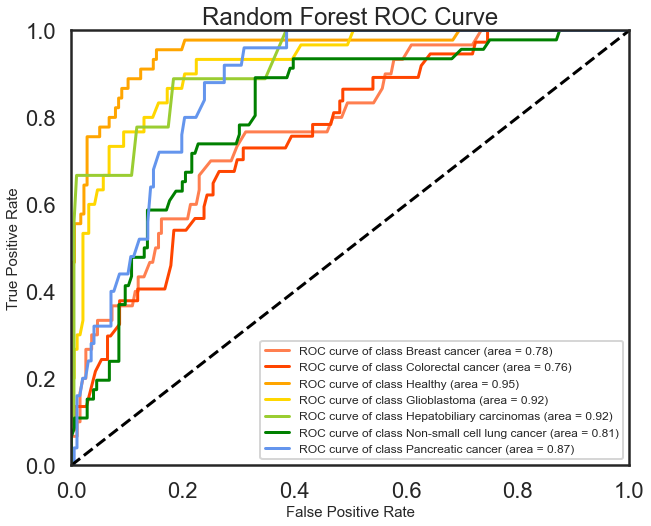

In [54]:
# Plot ROC for Random Forest Model
class_lookup =  {0: 'Breast cancer', 1: 'Colorectal cancer', 2: 'Healthy', 3: 'Glioblastoma', 
                 4: 'Hepatobiliary carcinomas', 5: 'Non-small cell lung cancer', 6: 'Pancreatic cancer'}
fig, ax = plt.subplots(figsize=(10,8))
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Random Forest ROC Curve', ax)

Confusion matrix, without normalization
[[2 2 1 0 0 2 1]
 [0 5 0 0 0 2 0]
 [0 0 9 0 0 0 0]
 [0 1 2 4 0 1 0]
 [0 1 0 0 1 1 0]
 [0 1 2 1 0 9 0]
 [0 5 0 0 0 0 3]]
Normalized confusion matrix
[[0.25       0.25       0.125      0.         0.         0.25
  0.125     ]
 [0.         0.71428571 0.         0.         0.         0.28571429
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.125      0.25       0.5        0.         0.125
  0.        ]
 [0.         0.33333333 0.         0.         0.33333333 0.33333333
  0.        ]
 [0.         0.07692308 0.15384615 0.07692308 0.         0.69230769
  0.        ]
 [0.         0.625      0.         0.         0.         0.
  0.375     ]]


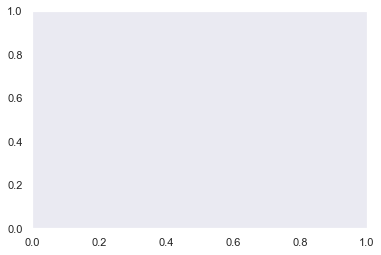

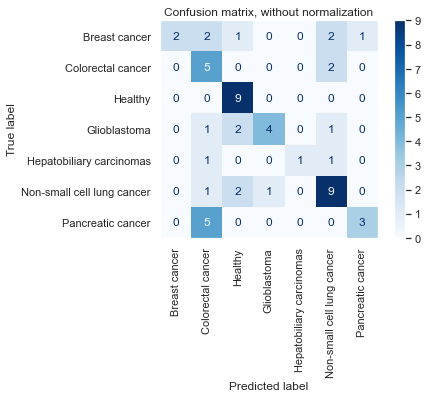

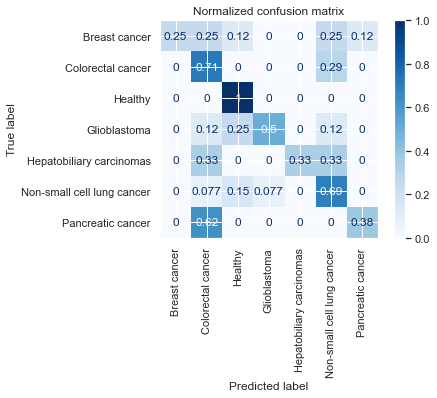

In [82]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names = ['Breast cancer', 'Colorectal cancer', 'Healthy', 'Glioblastoma', 
                 'Hepatobiliary carcinomas', 'Non-small cell lung cancer', 'Pancreatic cancer']

for title, normalize in titles_options:
    #sns.set(font_scale=1.0)
    plt.grid(False)
    disp = plot_confusion_matrix(estimator, X_test, Y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, xticks_rotation='vertical')
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

##### Feature importance analysis

In [55]:
forest = estimator.fit(X_train, Y_train)

In [56]:
estimator.feature_importances_

array([0.00011417, 0.00260032, 0.00051377, ..., 0.00011029, 0.00037241,
       0.00013339])

In [57]:
sorted_feature_important=sorted(zip(map(lambda x: round(x, 4),  estimator.feature_importances_), column_name), 
             reverse=True)

In [58]:
sorted_feature_important[0:19]

[(0.0052, 'ENSG00000155657'),
 (0.0052, 'ENSG00000142089'),
 (0.0042, 'ENSG00000168685'),
 (0.004, 'ENSG00000243317'),
 (0.0038, 'ENSG00000266402'),
 (0.0038, 'ENSG00000140105'),
 (0.0038, 'ENSG00000126353'),
 (0.0036, 'ENSG00000163492'),
 (0.0035, 'ENSG00000171858'),
 (0.0033, 'ENSG00000116251'),
 (0.0033, 'ENSG00000096060'),
 (0.0033, 'ENSG00000087460'),
 (0.0032, 'ENSG00000103316'),
 (0.0031, 'ENSG00000137198'),
 (0.003, 'ENSG00000196154'),
 (0.003, 'ENSG00000186854'),
 (0.003, 'ENSG00000174501'),
 (0.0029, 'ENSG00000251562'),
 (0.0029, 'ENSG00000136003')]

#### KNN

select K value

In [59]:
dt = grid_search_dt.best_estimator_
#dt = DecisionTreeClassifier()
probs_dt = cross_val_predict(dt, X_train, Y_train, cv=kfold, method='predict_proba')
dt.fit(X_train, Y_train) 
dt.score(X_test, Y_test)

0.44642857142857145

In [60]:
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probs_dt))

Cross validation accuracy:
	 0.45495495495495497

Cross validation classification report

              precision    recall  f1-score   support

           0       0.41      0.30      0.35        30
           1       0.44      0.38      0.41        37
           2       0.70      0.69      0.70        45
           3       0.44      0.50      0.47        30
           4       0.30      0.33      0.32         9
           5       0.42      0.41      0.42        46
           6       0.29      0.40      0.33        25

   micro avg       0.45      0.45      0.45       222
   macro avg       0.43      0.43      0.43       222
weighted avg       0.46      0.45      0.46       222
 samples avg       0.45      0.45      0.45       222



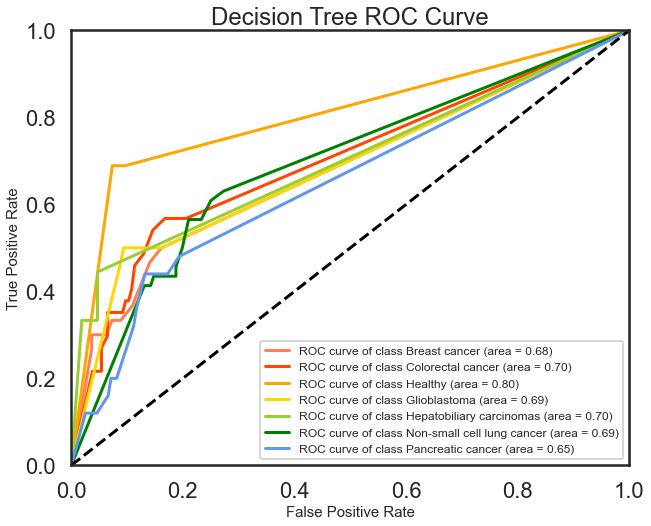

In [61]:
class_lookup =  {0: 'Breast cancer', 1: 'Colorectal cancer', 2: 'Healthy', 3: 'Glioblastoma', 
                 4: 'Hepatobiliary carcinomas', 5: 'Non-small cell lung cancer', 6: 'Pancreatic cancer'}
fig, ax = plt.subplots(figsize=(10,8))
create_roc_curve(Y_one_hot, probs_dt, class_lookup, 'Decision Tree ROC Curve', ax)

In [62]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
probs_mlp = cross_val_predict(mlp, X_train, Y_train, cv=kfold, method='predict_proba')
mlp.fit(X_train, Y_train)
mlp.score(X_test, Y_test)

0.5178571428571429

In [63]:
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probs_mlp))

Cross validation accuracy:
	 0.5585585585585585

Cross validation classification report

              precision    recall  f1-score   support

           0       0.42      0.43      0.43        30
           1       0.41      0.41      0.41        37
           2       0.80      0.87      0.83        45
           3       0.85      0.57      0.68        30
           4       0.50      0.22      0.31         9
           5       0.47      0.59      0.52        46
           6       0.46      0.44      0.45        25

   micro avg       0.56      0.56      0.56       222
   macro avg       0.56      0.50      0.52       222
weighted avg       0.57      0.56      0.56       222
 samples avg       0.56      0.56      0.56       222



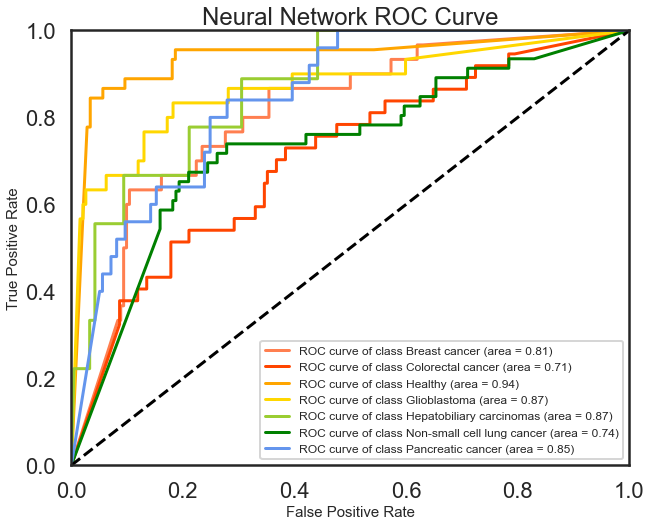

In [64]:
class_lookup =  {0: 'Breast cancer', 1: 'Colorectal cancer', 2: 'Healthy', 3: 'Glioblastoma', 
                 4: 'Hepatobiliary carcinomas', 5: 'Non-small cell lung cancer', 6: 'Pancreatic cancer'}
fig, ax = plt.subplots(figsize=(10,8))
create_roc_curve(Y_one_hot, probs_mlp, class_lookup, 'Neural Network ROC Curve', ax)

Confusion matrix, without normalization
[[2 0 0 1 1 2 2]
 [0 1 0 0 0 2 4]
 [1 0 7 1 0 0 0]
 [0 1 1 5 0 0 1]
 [0 0 0 0 0 1 2]
 [0 1 1 1 0 8 2]
 [0 1 0 1 0 0 6]]
Normalized confusion matrix
[[0.25       0.         0.         0.125      0.125      0.25
  0.25      ]
 [0.         0.14285714 0.         0.         0.         0.28571429
  0.57142857]
 [0.11111111 0.         0.77777778 0.11111111 0.         0.
  0.        ]
 [0.         0.125      0.125      0.625      0.         0.
  0.125     ]
 [0.         0.         0.         0.         0.         0.33333333
  0.66666667]
 [0.         0.07692308 0.07692308 0.07692308 0.         0.61538462
  0.15384615]
 [0.         0.125      0.         0.125      0.         0.
  0.75      ]]


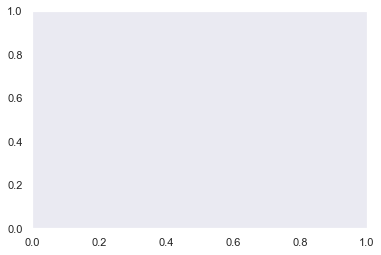

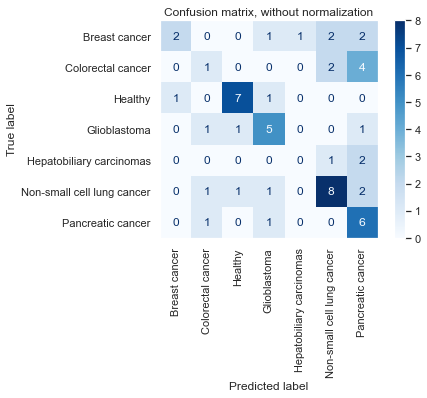

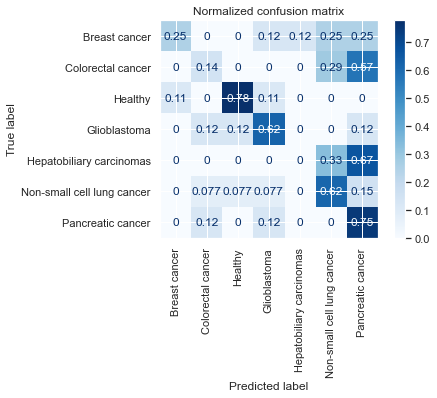

In [81]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names = ['Breast cancer', 'Colorectal cancer', 'Healthy', 'Glioblastoma', 
                 'Hepatobiliary carcinomas', 'Non-small cell lung cancer', 'Pancreatic cancer']

for title, normalize in titles_options:
    #sns.set(font_scale=1.0)
    plt.grid(False)
    disp = plot_confusion_matrix(mlp, X_test, Y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, xticks_rotation='vertical')
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [65]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 5)
probs_knn = cross_val_predict(knn, X_train, Y_train, cv=kfold, method='predict_proba')
knn.fit(X_train, Y_train) 
knn.score(X_test, Y_test) 

0.32142857142857145

In [66]:
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probs_knn))

Cross validation accuracy:
	 0.3963963963963964

Cross validation classification report

              precision    recall  f1-score   support

           0       0.29      0.47      0.36        30
           1       0.26      0.30      0.28        37
           2       0.53      0.69      0.60        45
           3       0.48      0.33      0.39        30
           4       0.00      0.00      0.00         9
           5       0.41      0.30      0.35        46
           6       0.47      0.32      0.38        25

   micro avg       0.40      0.40      0.40       222
   macro avg       0.35      0.34      0.34       222
weighted avg       0.39      0.40      0.38       222
 samples avg       0.40      0.40      0.40       222



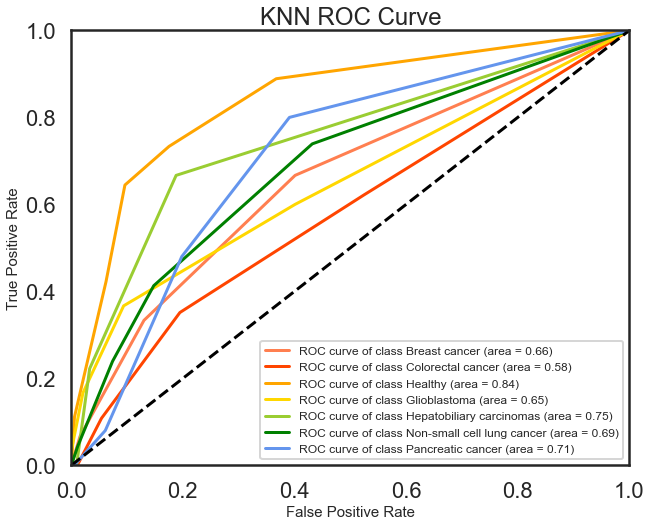

In [54]:
class_lookup =  {0: 'Breast cancer', 1: 'Colorectal cancer', 2: 'Healthy', 3: 'Glioblastoma', 
                 4: 'Hepatobiliary carcinomas', 5: 'Non-small cell lung cancer', 6: 'Pancreatic cancer'}
fig, ax = plt.subplots(figsize=(10,8))
create_roc_curve(Y_one_hot, probs_knn, class_lookup, 'KNN ROC Curve', ax)

In [67]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [70]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=2047, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [71]:
nn = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
probs_nn = cross_val_predict(nn, X_train, Y_train, cv=kfold, method='predict_proba')
nn.fit(X_train, Y_train) 
nn.score(X_test, Y_test) 

Instructions for updating:
Use tf.cast instead.


0.1428571492433548

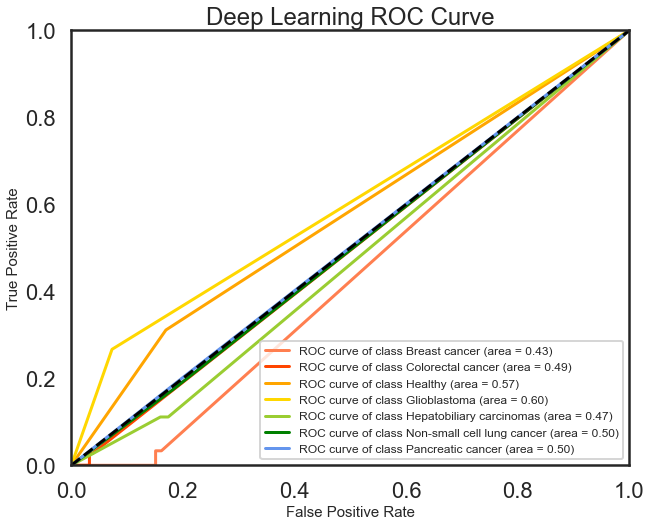

In [55]:
class_lookup =  {0: 'Breast cancer', 1: 'Colorectal cancer', 2: 'Healthy', 3: 'Glioblastoma', 
                 4: 'Hepatobiliary carcinomas', 5: 'Non-small cell lung cancer', 6: 'Pancreatic cancer'}
fig, ax = plt.subplots(figsize=(10,8))
create_roc_curve(Y_one_hot, probs_nn, class_lookup, 'Deep Learning ROC Curve', ax)